In [1]:
import pickle
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with gzip.open("../00.data/clustering/df_clustering.pkl.gz", "rb") as f:
    df_clustering = pickle.load(f)

In [3]:
df_clustering.head()

,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments,category,cluster_3
0,115,651,410,57,1,58,30,Política y Sociedad,1
1,77,982,362,50,2,27,24,Entretenimiento y Cultura,1
2,97,761,369,50,0,47,70,Política y Sociedad,1
3,141,505,352,77,1,64,53,Política y Sociedad,1
4,213,335,349,99,1,114,28,Política y Sociedad,1


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar solo las variables numéricas
num_features = ['meneos', 'clicks', 'karma', 'positive_votes', 'anonymous_votes', 'negative_votes', 'comments']
scaler = MinMaxScaler()

# Aplicar transformación y asegurar tipo float32
df_clustering.loc[:, num_features] = scaler.fit_transform(df_clustering[num_features]).astype('float32')

# Guardar el escalador
with gzip.open("../00.data/clustering/scaler.pkl.gz", "wb") as f:
    pickle.dump(scaler, f, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open("scaler.pkl", "wb") as f:
#    pickle.dump(scaler, f)

C:\Users\Jordi\AppData\Local\Temp\ipykernel_26232\1726708024.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0090917  0.00580137 0.00753312 ... 0.03151788 0.02840073 0.02346523]' has dtype incompatible with uint16, please explicitly cast to a compatible dtype first.
  df_clustering.loc[:, num_features] = scaler.fit_transform(df_clustering[num_features]).astype('float32')
C:\Users\Jordi\AppData\Local\Temp\ipykernel_26232\1726708024.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00221029 0.0033341  0.00258376 ... 0.00260413 0.00569038 0.00215596]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_clustering.loc[:, num_features] = scaler.fit_transform(df_clustering[num_features]).astype('float32')
C:\Users\Jordi\AppData\Local\Temp\ipykernel_26232\1726708024.py:8: FutureWarning: Setting an it

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar OneHotEncoder a la categoría
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' evita colinealidad
encoded_cats = encoder.fit_transform(df_clustering[['category']])

# Convertir a DataFrame
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(['category']))

# Resetear índice para asegurar alineación antes de la concatenación
df_clustering = df_clustering.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Unir con el dataset original
df_clustering = pd.concat([df_clustering, encoded_df], axis=1)

# Eliminar la columna categórica original
df_clustering.drop(columns=['category'], inplace=True)

# Guardar el encoder
with gzip.open("../00.data/clustering/encoder.pkl.gz", "wb") as f:
    pickle.dump(encoder, f, protocol=pickle.HIGHEST_PROTOCOL)


In [6]:
from sklearn.model_selection import train_test_split

# Definir X (features) e y (target)
X = df_clustering.drop(columns=['cluster_3'])
y = df_clustering['cluster_3']

# Dividir en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Ver distribución original de clases
class_counts = Counter(y_train)
print("Distribución original:", class_counts)

# Definir nueva cantidad de muestras por clase
smote_strategy = {k: int(v * 1.5) for k, v in class_counts.items()}  # Aumentar en 50%
undersample_strategy = {k: int(v * 0.8) for k, v in class_counts.items()}  # Reducir en 20%

# Crear balanceo
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)

# Crear pipeline
resampling_pipeline = Pipeline([
    ("SMOTE", smote),
    ("UnderSampling", undersample)
])

# Aplicar balanceo
X_train_res, y_train_res = resampling_pipeline.fit_resample(X_train, y_train)

# Ver nueva distribución de clases
print("Distribución después del balanceo:", Counter(y_train_res))

Distribución original: Counter({1: 187440, 0: 35472, 2: 7138})
Distribución después del balanceo: Counter({1: 149952, 0: 28377, 2: 5710})


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Definir modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar
rf.fit(X_train_res, y_train_res)

# Evaluar
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8868
           1       1.00      1.00      1.00     46861
           2       0.99      0.97      0.98      1784

    accuracy                           1.00     57513
   macro avg       0.99      0.99      0.99     57513
weighted avg       1.00      1.00      1.00     57513



In [10]:
### modelo demasiado bueno??

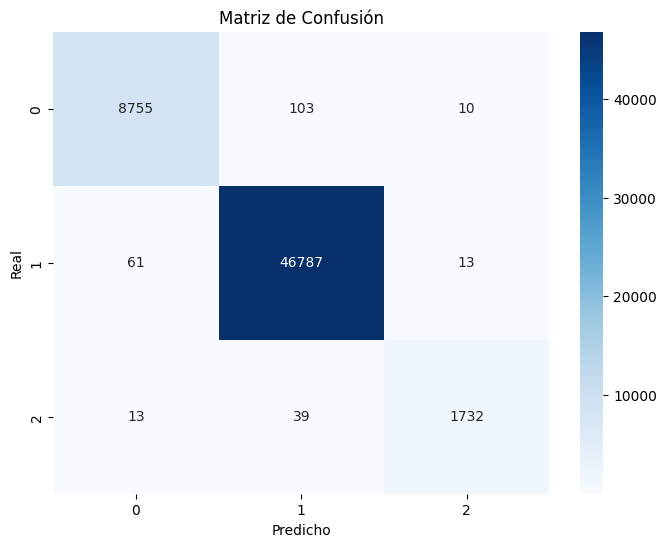

In [11]:
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

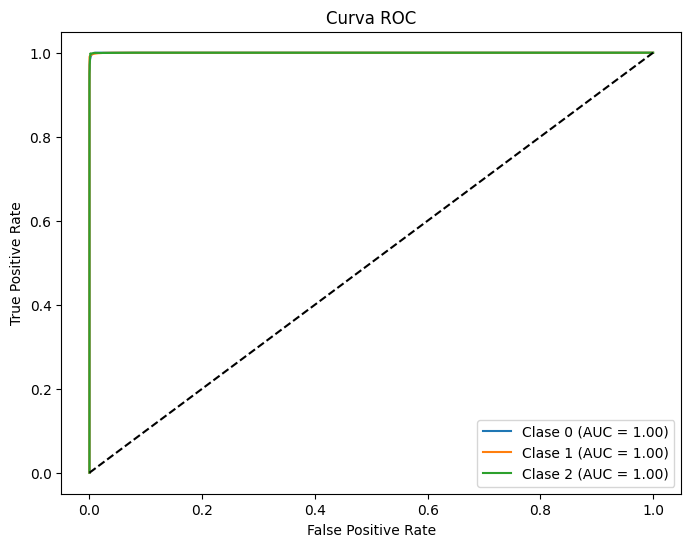

In [12]:
from sklearn.metrics import roc_curve, auc

# Calcular ROC-AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(set(y_test))  # Ajuste dinámico del número de clases

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [13]:
#### Comprobaciones para ver si ha habido overfitting

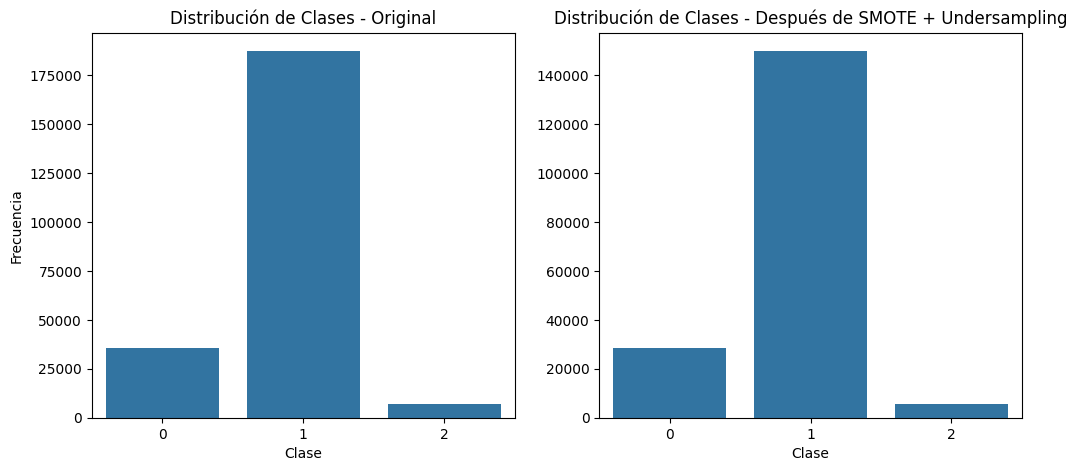

In [14]:
# Comparar distribución de clases original y después del balanceo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=axes[0])
axes[0].set_title("Distribución de Clases - Original")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Frecuencia")

# Después de balanceo
balanced_counts = {k: sum(y_train_res == k) for k in set(y_train_res)}
sns.barplot(x=list(balanced_counts.keys()), y=list(balanced_counts.values()), ax=axes[1])
axes[1].set_title("Distribución de Clases - Después de SMOTE + Undersampling")
axes[1].set_xlabel("Clase")

plt.show()


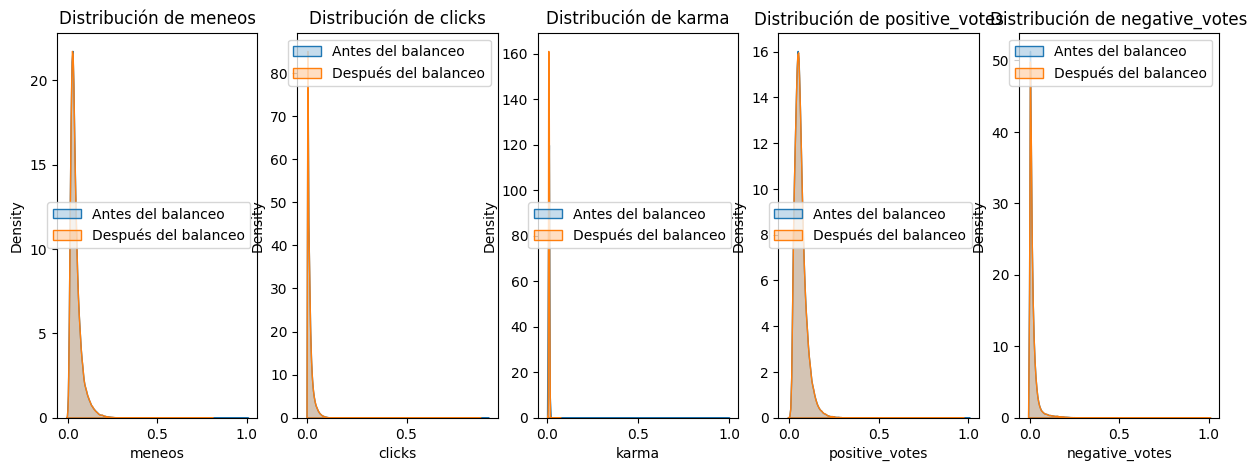

📌 meneos: La media de meneos ha disminuido tras el balanceo.
📌 clicks: La media de clicks ha disminuido tras el balanceo.
📌 karma: La media de karma ha disminuido tras el balanceo.
📌 positive_votes: La media de positive_votes ha disminuido tras el balanceo.
📌 negative_votes: La media de negative_votes ha disminuido tras el balanceo.


In [15]:
# Características a visualizar
features_to_check = ['meneos', 'clicks', 'karma', 'positive_votes', 'negative_votes']

# Diccionario para almacenar comentarios automáticos
comments = {}

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_check, 1):
    plt.subplot(1, len(features_to_check), i)
    
    # Graficar la distribución antes y después del balanceo
    sns.kdeplot(X_train[feature], label="Antes del balanceo", fill=True)
    sns.kdeplot(X_train_res[feature], label="Después del balanceo", fill=True)
    
    plt.title(f'Distribución de {feature}')
    plt.legend()

    # Generar comentario automático
    mean_before = X_train[feature].mean()
    mean_after = X_train_res[feature].mean()
    
    if mean_after > mean_before:
        comment = f"La media de {feature} ha aumentado tras el balanceo."
    elif mean_after < mean_before:
        comment = f"La media de {feature} ha disminuido tras el balanceo."
    else:
        comment = f"La media de {feature} se ha mantenido estable tras el balanceo."
    
    comments[feature] = comment

plt.show()

# Mostrar comentarios generados
for feature, comment in comments.items():
    print(f"📌 {feature}: {comment}")


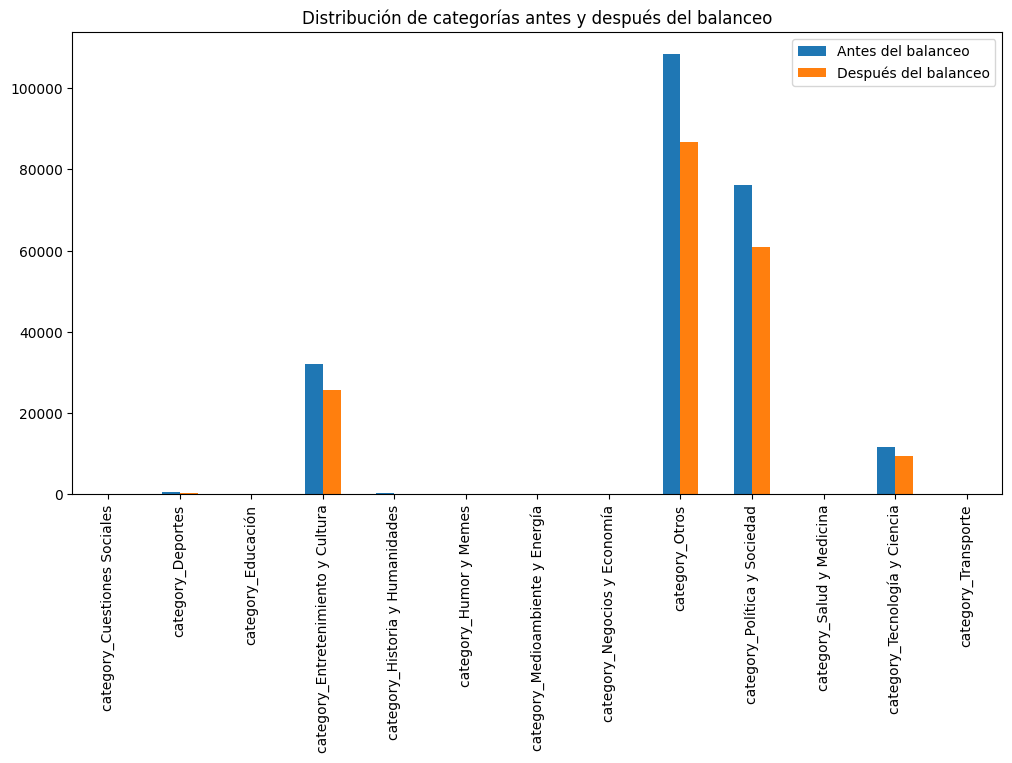

In [16]:
# Contar frecuencia de cada categoría antes y después del balanceo
category_cols = [col for col in X_train.columns if col.startswith("category_")]
category_counts_before = X_train[category_cols].sum()
category_counts_after = X_train_res[category_cols].sum()

# Unir los datos en un DataFrame
df_counts = pd.DataFrame({"Antes del balanceo": category_counts_before, "Después del balanceo": category_counts_after})

# Graficar
df_counts.plot(kind="bar", figsize=(12, 6), title="Distribución de categorías antes y después del balanceo")
plt.xticks(rotation=90)
plt.show()
